**Источники, которыми вдохновлялся:**
1) https://huggingface.co/microsoft/resnet-18
2) https://habr.com/ru/companies/magnus-tech/articles/850070/

# Подготовка к обучению

In [1]:
!pip install torch torchvision

In [ ]:
import torch

## Загрузка модели

In [2]:
import torch.nn as nn
from torchvision.models import resnet18

model = resnet18(weights="IMAGENET1K_V1")

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 175MB/s]


## Заморозка слоев (partial fine-tuning)

In [16]:
for param in model.parameters():
    param.requires_grad = False

num_classes = 10
in_features = model.fc.in_features
model.fc = nn.Linear(in_features, num_classes)

for param in model.layer4.parameters():
    param.requires_grad = True

In [9]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

## Загрузка даты

In [4]:
!wget https://zenodo.org/record/7711810/files/EuroSAT_RGB.zip?download=1 -O /content/EuroSAT_RGB.zip

!unzip -q /content/EuroSAT_RGB.zip -d /content/EuroSAT_RGB

--2025-11-23 09:09:00--  https://zenodo.org/record/7711810/files/EuroSAT_RGB.zip?download=1
Resolving zenodo.org (zenodo.org)... 137.138.52.235, 188.185.43.153, 188.185.48.75, ...
Connecting to zenodo.org (zenodo.org)|137.138.52.235|:443... connected.
HTTP request sent, awaiting response... 301 MOVED PERMANENTLY
Location: /records/7711810/files/EuroSAT_RGB.zip [following]
--2025-11-23 09:09:00--  https://zenodo.org/records/7711810/files/EuroSAT_RGB.zip
Reusing existing connection to zenodo.org:443.
HTTP request sent, awaiting response... 200 OK
Length: 94658721 (90M) [application/octet-stream]
Saving to: ‘/content/EuroSAT_RGB.zip’

/content/EuroSAT_RG 100%[===================>]  90.27M  26.1MB/s    in 3.5s    

2025-11-23 09:09:04 (26.1 MB/s) - ‘/content/EuroSAT_RGB.zip’ saved [94658721/94658721]



## Подготовка даты

In [5]:
!find /content/EuroSAT_RGB -maxdepth 2 -type d

/content/EuroSAT_RGB
/content/EuroSAT_RGB/EuroSAT_RGB
/content/EuroSAT_RGB/EuroSAT_RGB/Residential
/content/EuroSAT_RGB/EuroSAT_RGB/PermanentCrop
/content/EuroSAT_RGB/EuroSAT_RGB/River
/content/EuroSAT_RGB/EuroSAT_RGB/SeaLake
/content/EuroSAT_RGB/EuroSAT_RGB/Forest
/content/EuroSAT_RGB/EuroSAT_RGB/AnnualCrop
/content/EuroSAT_RGB/EuroSAT_RGB/Industrial
/content/EuroSAT_RGB/EuroSAT_RGB/Pasture
/content/EuroSAT_RGB/EuroSAT_RGB/Highway
/content/EuroSAT_RGB/EuroSAT_RGB/HerbaceousVegetation


**Применяем аугментацию**

In [17]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

# сделаем аугментацию, чтобы модель лучше обучалась
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(20),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# здесь не будем делать аугментацию, чобы модель валидировалась на реальных данных
val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# загружаем данные
dataset = datasets.ImageFolder(
    root="/content/EuroSAT_RGB/EuroSAT_RGB"
)


train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_dataset.dataset.transform = train_transform
val_dataset.dataset.transform = val_transform

train_loader = DataLoader(
    train_dataset,
    batch_size=32,
    shuffle=True,
    num_workers=2,
    pin_memory=True
)

val_loader = DataLoader(
    val_dataset,
    batch_size=32,
    shuffle=False,
    num_workers=2,
    pin_memory=True
)

print(f"Train samples: {len(train_dataset)}, Validation samples: {len(val_dataset)}")

Train samples: 21600, Validation samples: 5400


## Функция потерь и оптимизатор

1) Функция потерь - CrossEntropyLoss
2) Оптимизатор — Adam

In [18]:
import torch.optim as optim
criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(
    # обновляем веса только двух слоев (новый, который создали и внешний слой исходной модели)
    list(model.fc.parameters()) + list(model.layer4.parameters()),
    #маленький шаг, чтобы лучше настроить модель
    lr=1e-4
)

# Обучение

In [21]:
device = 'cpu'
model = model.to(device)

In [22]:
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0


    for i, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)


        print(f"[Train] Epoch {epoch+1}/{num_epochs}, Batch {i+1}/{len(train_loader)}, Loss: {loss.item():.4f}")

    epoch_loss = running_loss / len(train_loader.dataset)


    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_acc = correct / total


    print(f"\nEpoch {epoch+1}/{num_epochs}")
    print(f"Train Loss: {epoch_loss:.4f}")
    print(f"Validation Accuracy: {val_acc:.4f}\n")

Выходные данные были обрезаны до нескольких последних строк (5000).
[Train] Epoch 3/10, Batch 441/675, Loss: 0.0052
[Train] Epoch 3/10, Batch 442/675, Loss: 0.1144
[Train] Epoch 3/10, Batch 443/675, Loss: 0.1341
[Train] Epoch 3/10, Batch 444/675, Loss: 0.0530
[Train] Epoch 3/10, Batch 445/675, Loss: 0.0531
[Train] Epoch 3/10, Batch 446/675, Loss: 0.0321
[Train] Epoch 3/10, Batch 447/675, Loss: 0.0305
[Train] Epoch 3/10, Batch 448/675, Loss: 0.0077
[Train] Epoch 3/10, Batch 449/675, Loss: 0.0127
[Train] Epoch 3/10, Batch 450/675, Loss: 0.0056
[Train] Epoch 3/10, Batch 451/675, Loss: 0.0705
[Train] Epoch 3/10, Batch 452/675, Loss: 0.0094
[Train] Epoch 3/10, Batch 453/675, Loss: 0.0105
[Train] Epoch 3/10, Batch 454/675, Loss: 0.1444
[Train] Epoch 3/10, Batch 455/675, Loss: 0.0210
[Train] Epoch 3/10, Batch 456/675, Loss: 0.0350
[Train] Epoch 3/10, Batch 457/675, Loss: 0.0127
[Train] Epoch 3/10, Batch 458/675, Loss: 0.0740
[Train] Epoch 3/10, Batch 459/675, Loss: 0.1161
[Train] Epoch 3/10, 

# Визуализация

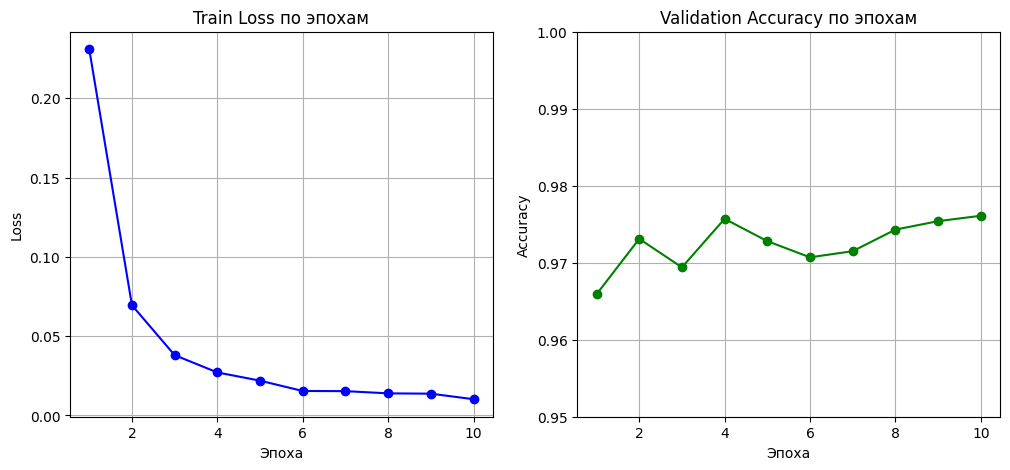

In [23]:
import matplotlib.pyplot as plt

train_losses = [0.2310, 0.0695, 0.0380, 0.0271, 0.0219, 0.0154, 0.0153, 0.0139, 0.0137, 0.0102]
val_accuracies = [0.9659, 0.9731, 0.9694, 0.9757, 0.9728, 0.9707, 0.9715, 0.9743, 0.9754, 0.9761]
epochs = range(1, 11)

# график Loss
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(epochs, train_losses, marker='o', color='blue')
plt.title("Train Loss по эпохам")
plt.xlabel("Эпоха")
plt.ylabel("Loss")
plt.grid(True)

# график Accuracy
plt.subplot(1,2,2)
plt.plot(epochs, val_accuracies, marker='o', color='green')
plt.title("Validation Accuracy по эпохам")
plt.xlabel("Эпоха")
plt.ylabel("Accuracy")
plt.ylim(0.95,1.0)
plt.grid(True)

plt.show()

# Вывод

1) В рамках работы была использована предобученная модель ResNet18, у которой мы заморозили все слои, кроме `layer4` и финального классификатора `fc`.  
Таким образом обучались только высокоуровневые признаки, что позволило эффективно адаптировать модель под EuroSAT без переобучения и с минимальными вычислительными затратами.

2) Оптимизатор Adam был настроен таким образом, чтобы обновлять параметры исключительно этих размороженных слоёв.  
Такой подход снижает риск переобучения, ускоряет обучение и обеспечивает более точную адаптацию модели под нашу задачу.

**В процессе обучения наблюдалось устойчивое снижение train loss и рост точности на валидации (за 10 эпох):**

- **Train Loss:** снизился с 0.2310 до **0.0102**
- **Validation Accuracy:** вырос с 0.9659 до **0.9761**



Полученные значения метрик показывают, что частичное размораживание модели и дообучение верхних слоёв обеспечивает высокое качество классификации на EuroSAT. Такой подход подтверждает эффективность transfer learning при работе с ограниченными данными и большими предобученными архитектурами.
